In [1]:
!pip install -qq transformers
!pip install -qq datasets


     |████████████████████████████████| 3.5 MB 14.6 MB/s 
     |████████████████████████████████| 596 kB 81.8 MB/s 
     |████████████████████████████████| 895 kB 81.5 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 6.8 MB 89.8 MB/s 
     |████████████████████████████████| 311 kB 13.5 MB/s 
     |████████████████████████████████| 133 kB 81.4 MB/s 
     |████████████████████████████████| 243 kB 89.3 MB/s 
     |████████████████████████████████| 1.1 MB 81.5 MB/s 
     |████████████████████████████████| 144 kB 80.3 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |████████████████████████████████| 271 kB 88.4 MB/s 


In [2]:
import transformers
import datasets
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AdamW, get_linear_schedule_with_warmup,Trainer, TrainingArguments
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import random
from datetime import datetime
from datasets import load_from_disk
from datasets import Dataset
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [3]:
# the model we gonna train, base uncased BERT
# check text classification models here: https://huggingface.co/models?filter=text-classification
MODEL_NAME = "distilbert-base-uncased"
# max sequence length for each document/sentence sample
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE= 6.58e-05
WEIGHT_DECAY = 0.289
WARMUP_STEPS = 464
RANDOM_SEED=22


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
def set_seed(seed):
    """Set all seeds to make results reproducible (deterministic mode).
       When seed is None, disables deterministic mode.
    :param seed: an integer to your choosing
    """
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
  acc = accuracy_score(labels, preds)
  confusion_matrix = classification_report(labels, preds, digits=4,output_dict=True)
  return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hate_f1': confusion_matrix["0"]["f1-score"],
        'hate_recall': confusion_matrix["0"]["recall"],
        'hate_precision': confusion_matrix["0"]["precision"],
        'offensive_f1': confusion_matrix["1"]["f1-score"],
        'offensive_recall': confusion_matrix["1"]["recall"],
        'offensive_precision': confusion_matrix["1"]["precision"],
        'normal_f1': confusion_matrix["2"]["f1-score"],
        'normal_recall': confusion_matrix["2"]["recall"],
        'normal_precision': confusion_matrix["2"]["precision"],    
  }

def model_init():
  temp_model =  AutoModelForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=3).to(device)
  return temp_model

def timestamp():
    dateTimeObj = datetime.now()
    timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S.%f)")
    print(timestampStr)

In [5]:
set_seed(RANDOM_SEED)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [7]:
result_list = []
for i in range(1,11):

  training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/'+str(i),          # output directory
    num_train_epochs=EPOCHS,              # total number of training epochs
    save_strategy ="epoch" ,
    per_device_train_batch_size=BATCH_SIZE,  # batch size per device during training
    per_device_eval_batch_size=BATCH_SIZE,   # batch size for evaluation
    weight_decay= WEIGHT_DECAY,               # strength of weight decay
    learning_rate= LEARNING_RATE, 
    warmup_steps = WARMUP_STEPS,
    logging_dir='./disbert_hate_baseline//logs',     # directory for storing logs
    load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
    evaluation_strategy="epoch",
  )

  hatetwit_dataset_dfs = load_from_disk('/content/drive/MyDrive/Dissertation/datasets/hatetwit_'+str(i))
  train_dataset = hatetwit_dataset_dfs ["train"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  eval_dataset = hatetwit_dataset_dfs ["validation"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  test_dataset = hatetwit_dataset_dfs ["test"].remove_columns(["input_ids_bert","attention_mask_bert","token_type_ids_bert"])
  model = model_init()
  trainer = Trainer(
      model=model,                         # the instantiated Transformers model to be trained
      args=training_args,                  # training arguments, defined above
      train_dataset= train_dataset,         # training dataset
      eval_dataset=eval_dataset,          # evaluation dataset
      compute_metrics=compute_metrics,     # the callback that computes metrics of interest
  )
  trainer.train()
  trainer.save_model('/content/drive/MyDrive/Dissertation/disbert_hate_baseline/models/model_'+str(i))
  results = trainer.evaluate(test_dataset)
  results["model_run"] = i
  result_list.append(results)




Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_clas

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.566800,0.535197,0.783215,0.741828,0.734362,0.751258,0.723384,0.765594,0.685586,0.859316,0.836727,0.883157,0.642784,0.651452,0.634343
2,0.427600,0.488667,0.810904,0.765317,0.774795,0.760947,0.780962,0.808853,0.754930,0.877225,0.894113,0.860963,0.637764,0.579876,0.708492
3,0.270900,0.554953,0.812406,0.771700,0.770010,0.775198,0.787152,0.825956,0.751832,0.878512,0.874121,0.882947,0.649435,0.625519,0.675252


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/1/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/1/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/1/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/1/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.571700,0.542782,0.777849,0.715615,0.746474,0.700767,0.706653,0.705231,0.708081,0.858193,0.907442,0.814015,0.581998,0.489627,0.717325
2,0.437200,0.514808,0.800386,0.761000,0.755515,0.769528,0.776790,0.835010,0.726159,0.866893,0.851166,0.883212,0.639318,0.622407,0.657174
3,0.258800,0.579757,0.809187,0.769425,0.766781,0.772604,0.788471,0.811871,0.766382,0.875559,0.870048,0.881140,0.644246,0.635892,0.652822


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/2/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/2/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/2/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/2/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.571700,0.570152,0.771196,0.714580,0.727324,0.709355,0.700772,0.730382,0.673469,0.853839,0.874861,0.833804,0.589129,0.522822,0.674699
2,0.441300,0.525531,0.793518,0.739883,0.756935,0.738575,0.756707,0.822938,0.700342,0.866836,0.884487,0.849875,0.596107,0.508299,0.720588
3,0.268300,0.596814,0.805538,0.765152,0.765978,0.764690,0.782738,0.793763,0.772016,0.870849,0.873750,0.867966,0.641870,0.626556,0.657952


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/3/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/3/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/3/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/3/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.574000,0.541478,0.777420,0.722352,0.742363,0.714959,0.715314,0.749497,0.684114,0.853916,0.881896,0.827658,0.597826,0.513485,0.715318
2,0.429700,0.533275,0.786435,0.752430,0.740029,0.775320,0.763828,0.875252,0.677570,0.851816,0.803406,0.906433,0.641645,0.647303,0.636086
3,0.261700,0.602442,0.804679,0.761973,0.762074,0.764689,0.789122,0.831992,0.750454,0.871111,0.870789,0.871434,0.625686,0.591286,0.664336


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/4/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/4/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/4/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/4/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.560600,0.543548,0.783645,0.728409,0.750430,0.717031,0.712234,0.723340,0.701463,0.860089,0.895594,0.827291,0.612903,0.532158,0.722535
2,0.420600,0.492091,0.811977,0.770262,0.771494,0.771658,0.783317,0.821932,0.748168,0.877634,0.878934,0.876338,0.649835,0.614108,0.689977
3,0.249700,0.600655,0.808328,0.766070,0.766433,0.766412,0.785258,0.803823,0.767531,0.876247,0.878193,0.874309,0.636704,0.617220,0.657459


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/5/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/5/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/5/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/5/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.576400,0.547402,0.777420,0.733990,0.734101,0.733878,0.726358,0.726358,0.726358,0.850481,0.850796,0.850166,0.625130,0.624481,0.625780
2,0.436800,0.493523,0.805752,0.768154,0.767369,0.769240,0.780849,0.795775,0.766473,0.867841,0.866716,0.868968,0.655772,0.645228,0.666667
3,0.261000,0.598802,0.806611,0.770173,0.764772,0.776345,0.794560,0.822938,0.768075,0.869598,0.856720,0.882869,0.646360,0.649378,0.643371


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/6/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/6/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/6/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/6/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.568900,0.548766,0.776991,0.735845,0.729500,0.744642,0.728383,0.779678,0.683422,0.850161,0.830803,0.870442,0.628990,0.623444,0.634636
2,0.428300,0.516198,0.796737,0.750777,0.760176,0.744888,0.766337,0.778672,0.754386,0.864023,0.883377,0.845500,0.621972,0.572614,0.680641
3,0.254900,0.601103,0.803606,0.763740,0.762155,0.765698,0.785644,0.803823,0.768269,0.869452,0.866716,0.872206,0.636124,0.626556,0.645989


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/7/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/7/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/7/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/7/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.569600,0.549209,0.780210,0.727418,0.738965,0.720883,0.725838,0.740443,0.711799,0.856988,0.879674,0.835443,0.599427,0.542531,0.669654
2,0.430400,0.506972,0.800601,0.754456,0.765238,0.745334,0.763845,0.735412,0.794565,0.871166,0.893743,0.849701,0.628357,0.606846,0.651448
3,0.259700,0.589525,0.813479,0.773480,0.773976,0.773474,0.801383,0.815895,0.787379,0.877608,0.880044,0.875184,0.641449,0.624481,0.659365


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/8/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/8/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/8/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/8/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.574800,0.546071,0.778708,0.727018,0.740043,0.717313,0.712315,0.701207,0.723780,0.854735,0.882266,0.828870,0.614006,0.568465,0.667479
2,0.437800,0.510202,0.798884,0.751382,0.762841,0.745201,0.762138,0.781690,0.743541,0.867365,0.888560,0.847158,0.624642,0.565353,0.697823
3,0.263400,0.613632,0.802103,0.761353,0.763571,0.759314,0.778672,0.778672,0.778672,0.867966,0.873750,0.862258,0.637421,0.625519,0.649784


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/9/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/9/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/9/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/9/checkpoint-4660
Configuration saved in /cont

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hate F1,Hate Recall,Hate Precision,Offensive F1,Offensive Recall,Offensive Precision,Normal F1,Normal Recall,Normal Precision
1,0.576000,0.539398,0.778493,0.711052,0.750693,0.694605,0.718338,0.713280,0.723469,0.859616,0.919289,0.807217,0.555201,0.451245,0.721393
2,0.432300,0.507200,0.811977,0.768351,0.779717,0.759164,0.775615,0.761569,0.790188,0.877073,0.900777,0.854584,0.652365,0.615145,0.694379
3,0.247000,0.575591,0.816270,0.775313,0.776013,0.775023,0.787129,0.799799,0.774854,0.882776,0.885228,0.880339,0.656034,0.640041,0.672846


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/10/checkpoint-2330
Configuration saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/10/checkpoint-2330/config.json
Model weights saved in /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/10/checkpoint-2330/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence.
***** Running Evaluation *****
  Num examples = 4659
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/Dissertation/disbert_hate_baseline/results/10/checkpoint-4660
Configuration saved in /

In [8]:
results_df = pd.DataFrame(result_list)
results_df.to_csv('/content/drive/MyDrive/Dissertation/results/distilbert_baselines.csv')

In [9]:
#Sort rows to determine the mix, max and median 
results_df = results_df.sort_values(by=['eval_f1'])
#Print min values
results_df.head(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
2,0.524914,0.798411,0.749282,0.761003,0.749298,0.753932,0.820745,0.697177,0.87017,0.88,0.860558,0.623745,0.54715,0.725275,3.9153,1189.691,74.579,3.0,3


In [10]:
#Print max values 
results_df.tail(1)

,eval_loss,eval_accuracy,eval_f1,eval_precision,eval_recall,eval_hate_f1,eval_hate_recall,eval_hate_precision,eval_offensive_f1,eval_offensive_recall,eval_offensive_precision,eval_normal_f1,eval_normal_recall,eval_normal_precision,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,model_run
6,0.511171,0.815157,0.769912,0.783891,0.760764,0.787575,0.791541,0.783649,0.879425,0.906296,0.854101,0.642735,0.584456,0.713924,3.8754,1201.952,75.348,3.0,7


In [11]:
#Print median f1
results_df["eval_f1"].median()

0.7577267614857477

In [12]:
#Print average values
results_df.mean()

eval_loss                      0.514836
eval_accuracy                  0.803049
eval_f1                        0.758755
eval_precision                 0.764466
eval_recall                    0.757894
eval_hate_f1                   0.771782
eval_hate_recall               0.802115
eval_hate_precision            0.746817
eval_offensive_f1              0.871258
eval_offensive_recall          0.878407
eval_offensive_precision       0.865375
eval_normal_f1                 0.633224
eval_normal_recall             0.593161
eval_normal_precision          0.681205
eval_runtime                   3.924650
eval_samples_per_second     1187.001100
eval_steps_per_second         74.410500
epoch                          3.000000
model_run                      5.500000
dtype: float64

In [13]:
results_df.std()

eval_loss                    0.013752
eval_accuracy                0.007213
eval_f1                      0.006414
eval_precision               0.011832
eval_recall                  0.009454
eval_hate_f1                 0.011321
eval_hate_recall             0.034178
eval_hate_precision          0.043059
eval_offensive_f1            0.006159
eval_offensive_recall        0.028199
eval_offensive_precision     0.019999
eval_normal_f1               0.011193
eval_normal_recall           0.029526
eval_normal_precision        0.025304
eval_runtime                 0.044901
eval_samples_per_second     13.500682
eval_steps_per_second        0.846298
epoch                        0.000000
model_run                    3.027650
dtype: float64

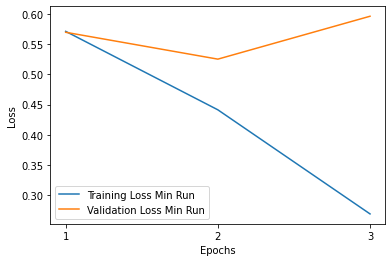

In [3]:
training_loss_min = [0.5717,0.441300,0.2683]
training_loss_max = [0.5689,0.42830,0.2549]
val_loss_min = [0.570152,0.525531,0.596814]
val_loss_max = [0.548766,0.5161,0.6011]
epoch_list=[1,2,3]

plt.figure()
plt.plot(epoch_list,training_loss_min, label="Training Loss Min Run")
plt.plot(epoch_list,val_loss_min, label="Validation Loss Min Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()


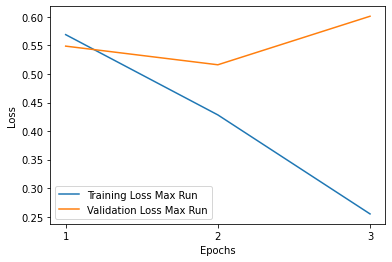

In [4]:

plt.figure()
plt.plot(epoch_list,training_loss_max, label="Training Loss Max Run")
plt.plot(epoch_list,val_loss_max, label="Validation Loss Max Run")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epoch_list)
plt.legend()
plt.show()